# Import thư viện

In [3]:
import os
import cv2
import dill
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%load_ext autotime

time: 178 μs (started: 2025-01-13 22:39:29 +07:00)


# Tạo dataset

In [4]:
def load_data_from_directory(directory_path, lr_size=(240, 240), hr_size=(480, 480)):
    """
    Tải dữ liệu từ thư mục và chia thành các patch nhỏ cho cả ảnh LR và HR.

    Tham số:
    - directory_path (str): Đường dẫn tới thư mục chứa các ảnh LR và HR.
    - lr_size (tuple, mặc định (240, 240)): Kích thước mà ảnh LR sẽ được thay đổi kích thước về.
    - hr_size (tuple, mặc định (480, 480)): Kích thước mà ảnh HR sẽ được thay đổi kích thước về.
    - patch_size (int, mặc định 60): Kích thước của mỗi patch được chia từ ảnh LR. Các patch HR sẽ có kích thước gấp đôi (patch_size*2).

    Lý thuyết hoạt động:
    - Hàm này tìm các ảnh có tên kết thúc bằng '_LR.png' trong thư mục chỉ định.
    - Tạo tên ảnh HR tương ứng bằng cách thay thế phần '_LR.png' bằng '_HR.png'.
    - Nếu ảnh HR tồn tại, nó sẽ được tải cùng với ảnh LR.
    - Các ảnh LR và HR sẽ được thay đổi kích thước về các giá trị `lr_size` và `hr_size` tương ứng.
    - Ảnh sau đó sẽ được chuẩn hóa về phạm vi giá trị [0, 1] (định dạng float32).
    - Mỗi ảnh sẽ được chia thành các patch nhỏ có kích thước `patch_size` cho ảnh LR và `patch_size*2` cho ảnh HR.
    - Tất cả các patch của ảnh LR và HR sẽ được thu thập và trả về.

    Trả về:
    - lr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh LR.
      Mảng có kích thước (n, patch_size, patch_size), trong đó n là số lượng patch.
    - hr_images (numpy.ndarray): Một mảng chứa tất cả các patch nhỏ từ ảnh HR.
      Mảng có kích thước (n, patch_size*2, patch_size*2), trong đó n là số lượng patch.

    Ví dụ:
    >>> lr_images, hr_images = load_data_from_directory('path/to/directory', lr_size=(240, 240), hr_size=(480, 480))
    >>> print(lr_images.shape)
    (n, 60, 60)  # n là số lượng patch LR
    >>> print(hr_images.shape)
    (n, 120, 120)  # n là số lượng patch HR

    Lưu ý:
    - Hàm yêu cầu các ảnh LR phải có tên kết thúc bằng '_LR.png' và ảnh HR tương ứng phải có tên kết thúc bằng '_HR.png'.
    - Chỉ các ảnh có cả hai tệp LR và HR sẽ được xử lý.
    """
    
    lr_images = []
    hr_images = []

    # Lặp qua tất cả các file trong thư mục
    for filename in os.listdir(directory_path):
        if filename.endswith('_LR.png'):  # Tìm ảnh LR
            # Tạo tên ảnh HR tương ứng
            hr_filename = filename.replace('_LR.png', '_HR.png')

            # Xây dựng đường dẫn đầy đủ cho ảnh LR và HR
            lr_path = os.path.join(directory_path, filename)
            hr_path = os.path.join(directory_path, hr_filename)

            if os.path.exists(hr_path):  # Kiểm tra xem ảnh HR có tồn tại không
                # Đọc ảnh LR và HR
                
                lr_img = cv2.imread(lr_path)  # Đọc ảnh màu
                hr_img = cv2.imread(hr_path)  # Đọc ảnh màu
                
                lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB) # Chuyển ảnh sang màu RGB
                
                # lr_img = cv2.imread(lr_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale (xám)
                # hr_img = cv2.imread(hr_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale (xám)

                if lr_img is not None and hr_img is not None:
                    # Resize ảnh về kích thước mong muốn
                    lr_img = cv2.resize(lr_img, lr_size)
                    hr_img = cv2.resize(hr_img, hr_size)

                    # Chuẩn hóa ảnh (0-1)
                    lr_img = lr_img.astype('float32') / 255.0
                    hr_img = hr_img.astype('float32') / 255.0

                    # Thêm các ảnh vào danh sách
                    lr_images.append(lr_img)
                    hr_images.append(hr_img)

    return lr_images, hr_images

time: 3.96 ms (started: 2025-01-13 22:39:31 +07:00)


In [5]:
directory_path = '/home/vodanhday/Downloads/Urban100/image_SRF_2'

lr_size = (240, 240)
hr_size = (480, 480)

lr_images, hr_images = load_data_from_directory(directory_path, lr_size, hr_size)

time: 1.47 s (started: 2025-01-13 22:39:33 +07:00)


In [6]:
test = hr_images[0][:, :, 0]
print(test.shape)

(480, 480)
time: 5.5 ms (started: 2025-01-13 22:39:37 +07:00)


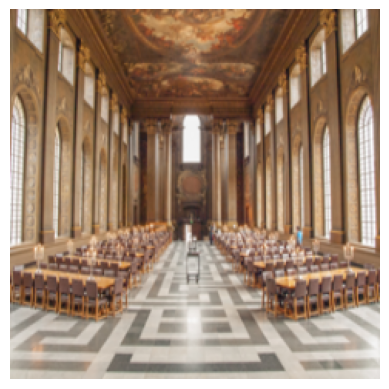

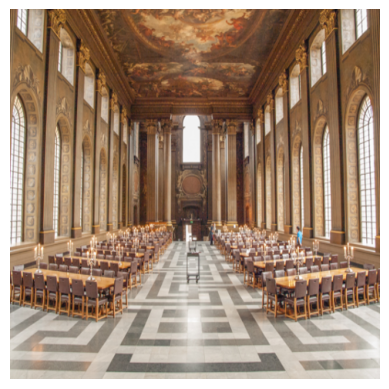

time: 331 ms (started: 2025-01-13 22:39:39 +07:00)


In [ ]:
plt.imshow(lr_images[0])
plt.axis('off')
plt.show()

plt.imshow(hr_images[0])
plt.axis('off')
plt.show()

# Thực hiện xây dựng model

- Các layer như Conv2D, Upscale không thực hiện tính toán. Mà chỉ thực hiện nhận dữ liệu và truyền dữ liệu đi.
- Để thực hiện tính toán sẽ thực hiện trong hàm forward và hàm backward.
- Việc tính toán sẽ dựa trên self.name để biết lớp hiện tại cần thực hiện gì.

- Ví dụ self.name = "Conv2D" thì sẽ thực hiện tính toán tích chập

In [14]:
class Layer():
    def __init__(self):
        self.shape = {
            'input': None,      # Kích thước của đầu vào
            'output': None      # Kích thước của đầu ra
        }
        self.weights = None     # Weights của lớp
        self.bias = None        # Bias của lớp
        self.activation = None  # Activation function của lớp, VD: "relu" có nghĩa lớp sử dụng hàm ReLU
        self.feature_map = {
            'Z': None,          # Đầu ra trước activation function
            'A': None,          # Đầu ra sau activation
            'A_prev': None      # Đầu ra của lớp trước đó
        }
        self.gradient = {
            'dW': None,         # Đạo hàm của loss function theo weights
            'db': None,         # Đạo hàm của loss function theo bias
            'dA': None,         # Đạo hàm của loss function theo A
            'dZ': None          # Đạo hàm của loss function theo Z
        }
        self.conv = {
            'stride': None,        # Bước trượt của convolution
            'padding': None,       # Padding của convolution
            'kernel_size': None,   # Kích thước kernel của convolution
            'num_filters': None    # Số lượng filter của convolution
        }
        self.name = []          # Tên của lớp
        
    def Input(self, shape):
        self.shape['input'] = shape
        self.shape['output'] = shape
        self.name.append('Input')
        return self
        
    def Upscale(self, scale=2):
        # Với input với kích thước là [height, width, channels]
        if len(self.shape['input']) == 3:
            self.shape['output'] = [self.shape['input'][0]*scale, self.shape['input'][1]*scale, self.shape['input'][2]]
        # Với input với kích thước là [height, width]
        else:
            self.shape['output'] = [self.shape['input'][0]*scale, self.shape['input'][1]*scale]      
        # Thêm tên của lớp
        self.name.append('Upscale')
        return self
    
    def Conv2D(self, num_filters, kernel_size, stride=1, padding=0, activation=None):
        self.conv['stride'] = stride
        self.conv['padding'] = padding
        self.conv['kernel_size'] = kernel_size
        self.conv['num_filters'] = num_filters
        self.activation = activation
        # Tính kích thước của output
        self.shape['output'] = [
            (self.shape['input'][0] - kernel_size + 2*padding) // stride + 1,
            (self.shape['input'][1] - kernel_size + 2*padding) // stride + 1,
            num_filters
        ]
        # Thêm tên của lớp
        self.name.append('Conv2D')
        self.name.append('Activation') if activation is not None else None
        return self
    
    def BatchNormalization(self):
        
        # Khởi tạo sau
        
        # Thêm tên của lớp
        self.name.append('BatchNormalization')
        return self
    
    def activate(self, Z):
        if self.activation == "relu":
            return np.maximum(0, Z)
        elif self.activation is None:
            return Z
        else:
            raise ValueError(f"Unsupported activation '{self.activation}'.")
        
    def activate_derivative(self, Z):
        if self.activation == "relu":
            return (Z > 0).astype(float)
        elif self.activation is None:
            return np.ones_like(Z)
        else:
            raise ValueError(f"Unsupported activation '{self.activation}'.")
        
    def forward(self, A_prev):
        
        # Thực hiện tích toán tại đây
        
        pass
    
    def backward(self, dA):
        
        # Thực hiện tại đây
        
        pass
    
    def update_params(self, learning_rate):
        if self.weights is not None:
            self.weights -= learning_rate * self.gradient['dW']
            self.bias -= learning_rate * self.gradient['db']
            
    def get_params(self):
        return {
            'weights': self.weights,
            'bias': self.bias,
            'activation': self.activation,
            'shape': self.shape,
            'conv': self.conv,
            'gradient': self.gradient,
            'feature_map': self.feature_map,
            'name': self.name
        }
        
    def set_params(self, params):
        self.weights = params['weights']
        self.bias = params['bias']
        self.activation = params['activation']
        self.shape = params['shape']
        self.conv = params['conv']
        self.gradient = params['gradient']
        self.feature_map = params['feature_map']
        self.name = params['name']
        
        return self

In [18]:
class SRCNN:
    def __init__(self):
        self.layers = []
        self.optimizer = {
            'loss_fn': None,
            'metrics': None
        }
        self.current_shape = None
        self.best_weights = None
        self.learning_rate = None
        self.continue_training = False
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_metric': [],
            'val_metric': []
        }
        
    def add(self, layer):
        self.current_shape = layer.shape['output']
        self.layers.append(layer)
        
    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward_pass(A)
        return A
    
    def backward(self, output, Y, learning_rate):
        m = Y.shape[0]
        dA = self._calculate_gradient(output, Y, grad_fn=self.loss_fn.__name__)
        for layer in reversed(self.layers):
            dA = layer.backward_pass(dA, m, learning_rate, self.batch)
            layer.update_parameters(learning_rate)
            
    def _calculate_gradient(self, output, Y, grad_fn='mse'):
        if grad_fn == 'mse':
            return 2 * (output - Y)
        else:
            raise ValueError(f"Unsupported loss function '{grad_fn}'.")
        
    def train(self, X_train, Y_train, epochs, learning_rate, batch_size=32, X_val=None, Y_val=None, early_stopping_rounds=7, lr_patience=3, lr_factor=0.2):
        best_val_loss = float('inf')
        no_improvement_rounds = 0
        current_lr = self.learning_rate if self.continue_training else learning_rate
        self.history["train_loss"] = self.history["train_loss"] if self.continue_training else []
        self.history["val_loss"] = self.history["val_loss"] if self.continue_training else []
        self.history["train_metric"] = self.history["train_metric"] if self.continue_training else []
        self.history["val_metric"] = self.history["val_metric"] if self.continue_training else []
        
        loss_func = self.optimizer['loss_fn']
        metric_func = self.optimizer['metrics'] 
        
        for epoch in range(epochs):
            progress_bar = tqdm(range(X_train.shape[0] // batch_size), desc=f"Epoch {epoch + 1}/{epochs}", unit="step")

            epoch_loss = 0
            epoch_score = 0
            for step in progress_bar:
                start = step * batch_size
                end = start + batch_size
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                output = self.forward(X_batch)

                loss = loss_func(output, Y_batch)
                epoch_loss += loss

                score = metric_func(output, Y_batch)
                epoch_score += score

                self.backward(output, Y_batch, learning_rate)

                progress_bar.set_postfix(loss=epoch_loss / (step + 1), **{metric_func.__name__: epoch_score / (step + 1)})

            train_loss = epoch_loss / (X_train.shape[0] // batch_size)
            train_metric = epoch_score / (X_train.shape[0] // batch_size)
            
            self.history["train_loss"].append(train_loss)
            self.history["train_metric"].append(train_metric)
                
            if X_val is not None and Y_val is not None:
                val_output = self.forward(X_val)
                val_loss = loss_func(val_output, Y_val)
                val_metric = metric_func(val_output, Y_val)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_rounds = 0
                    
                    self.best_weights = [layer.get_parameters() for layer in self.layers]
                else:
                    no_improvement_rounds += 1

                if early_stopping_rounds and no_improvement_rounds >= early_stopping_rounds:
                    print(f"Early stopping at epoch {epoch + 1}")
                    self.set_weights(self.best_weights)
                    break
                
                if no_improvement_rounds >= lr_patience:
                    print(f"Reducing learning rate by factor of {lr_factor}")
                    current_lr *= lr_factor
                    self.learning_rate = current_lr                    
            
                self.history["val_loss"].append(val_loss)
                self.history["val_metric"].append(metric_func(val_output, Y_val))
            
            if X_val is not None and Y_val is not None:
                print(f"Epoch {epoch + 1}/{epochs} - loss: {train_loss:.4f} - {metric_func.__name__}: {train_metric:.4f} - val_loss: {val_loss:.4f} - val_{metric_func.__name__}: {val_metric:.4f}")
            else:
                print(f"Epoch {epoch + 1}/{epochs} - loss: {train_loss:.4f} - {metric_func.__name__}: {train_metric:.4f}")
        
    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X, Y):
        output = self.forward(X)
        loss = self.optimizer['loss_fn'](output, Y)
        metric_value = self.optimizer['metrics'](output, Y)
        return loss, metric_value
    
    def compile(self, loss_fn, metrics):
        self.optimizer['loss_fn'] = loss_fn
        self.optimizer['metrics'] = metrics if metrics else []
        
    def get_weights(self):
        return [layer.get_params() for layer in self.layers]
    
    def set_weights(self, parameters):
        if len(self.layers) == 0:
            for weights in parameters:
                layer = Layer()
                layer.set_parameters(weights)
                self.add(layer)
        elif len(self.layers) == len(parameters):
            for i, weights in enumerate(parameters):
                self.layers[i].set_params(weights)
        else:
            raise ValueError("Number of layers in the model does not match the number of layers in the provided weights.")
            
    def get_model(self):
        weights = self.get_weights()
        parameters = {
            "weights": weights,
            "optimizer": self.optimizer,
            "history": self.history,
            "learning_rate": self.learning_rate
        }
        return parameters
    
    def load_model(self, model):
        self.set_weights(model["weights"])
        self.optimizer = model["optimizer"]
        self.history = model["history"]
        self.learning_rate = model["learning_rate"]
        
    def summary(self):
        total_params = 0
        print("Model Summary:")
        print("="*50)
        
        for i, layer in enumerate(self.layers):
            layer_name = layer.__class__.__name__
            for n in layer.name:
                layer_name += f" -> {n}"
            print(f"Layer {i+1}: {layer_name}")

            input_shape = layer.shape['input'] if layer.shape['input'] else 'None'
            output_shape = layer.shape['output'] if layer.shape['output'] else 'None'
            kernel_shape = layer.weights.shape if layer.weights is not None else 'None'
            print(f"  Input Shape: {input_shape}")
            print(f"  Kernel Shape: {kernel_shape}")
            print(f"  Output Shape: {output_shape}")

            num_params = 0
            if hasattr(layer, 'weights') and layer.weights is not None:
                num_params += np.prod(layer.weights.shape)
            if hasattr(layer, 'bias') and layer.bias is not None:
                num_params += np.prod(layer.bias.shape)
                
            total_params += num_params
            print(f"  Number of Parameters: {num_params}")
            print("-"*50)
        
        print(f"Total Parameters: {total_params}")
        print("="*50)

In [16]:
def mse_loss(predicted, target):
    return ((predicted - target) ** 2).mean()

def psnr_metric(predicted, target, max_val=1.0):
    mse = mse_loss(predicted, target)
    if(mse == 0):
        return 100
    psnr = 20 * np.log10(max_val / np.sqrt(mse)) 
    return psnr

In [19]:
model = SRCNN()

model.add(Layer().Input((240, 240, 3)).Upscale(scale=2))

num_filters = [64, 32, 3]
kernel_sizes = [9, 5, 3]

for kernel_size, num_filter in zip(kernel_sizes, num_filters):
    model.add(Layer().Input(model.current_shape).Conv2D(num_filter, kernel_size, activation="relu"))
    
model.compile(loss_fn=mse_loss, metrics=psnr_metric)
model.summary()

Model Summary:
Layer 1: Layer -> Input -> Upscale
  Input Shape: (240, 240, 3)
  Kernel Shape: None
  Output Shape: [480, 480, 3]
  Number of Parameters: 0
--------------------------------------------------
Layer 2: Layer -> Input -> Conv2D -> Activation
  Input Shape: [480, 480, 3]
  Kernel Shape: None
  Output Shape: [472, 472, 64]
  Number of Parameters: 0
--------------------------------------------------
Layer 3: Layer -> Input -> Conv2D -> Activation
  Input Shape: [472, 472, 64]
  Kernel Shape: None
  Output Shape: [468, 468, 32]
  Number of Parameters: 0
--------------------------------------------------
Layer 4: Layer -> Input -> Conv2D -> Activation
  Input Shape: [468, 468, 32]
  Kernel Shape: None
  Output Shape: [466, 466, 3]
  Number of Parameters: 0
--------------------------------------------------
Total Parameters: 0
